# Comparación con HITU simulator

Para verificar la correctitud de la rutina creada, se compararán los resultados que entrega HITU simulator al escoger ciertos parámetros. Estos se mencionarán más adelante. Usaremos 2 simulaciones, una que replique una aplicación real de las ondas de sonido, y otro que intenta modelar un poco más de tiempo, junto con el correspondiente enfriamiento.

Para comparar resultados, se calculará la mayor diferencia de temperatura en un tiempo.

In [14]:
import sys
sys.path.append('..')

import optimus
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

from utilities import finite_difference, rectangular_pulse, turk_pulse

En ambas simulaciones se usa el mismo heat deposition.

In [3]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')
IPP_abs_load = np.loadtxt("HEAD_0198 .txt")

c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a 

frequency = 500e3

Nx = 51
Ny = 51
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-0.03, 0.03, -0.03, 0.03, 0, 0.12]

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

IPP_abs = IPP_abs_load.reshape(
    IPP_abs_load.shape[0], IPP_abs_load.shape[1] // 51, 51) 

intensity = (IPP_abs)**2 / (2 * c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
heat_deposition = intensity.copy()
heat_deposition = 2 * alpha * intensity

## Simulación física real

In [103]:
delta_t = 0.3 / 100 #2e-5
Nt = 100 #int(1.5e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp = []

prev_temp = T_0 

time_domain = np.array(range(Nt)) * delta_t

In [104]:
%%time
for i in range(Nt):
    max_temp.append(np.max(prev_temp))
    
    prev_temp = finite_difference(temp_grid=prev_temp, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=1,
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


In [105]:
df = pd.read_csv('03_simulation.csv')
hitu_03 = df['37.000000000000000'].to_numpy()
hitu_03 = np.insert(hitu_03, 0, 37)

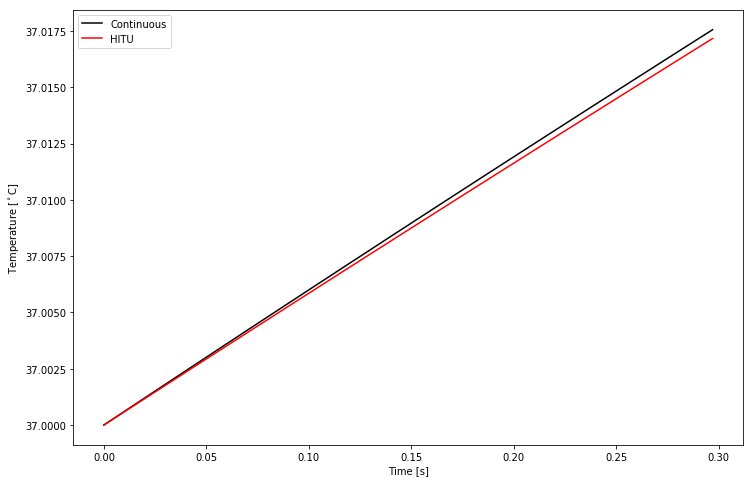

In [106]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain, max_temp, c='black', label = 'Continuous')
plt.plot(time_domain, hitu_03, c='red', label = 'HITU')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

In [107]:
dif = np.max(np.abs(hitu_03 - max_temp))
print('Diferencia máxima de',dif, 'grados.')
print('Error porcentual de',100 * dif / (np.max(max_temp)-37),'%')

Diferencia máxima de 0.00039175836660376717 grados.
Error porcentual de 2.230988781454548 %


## Simulación más tiempo con enfriamiento

In [96]:
delta_t = 0.01
Nt_heat = 200
Nt_cold = 300

T_0 = np.zeros_like(heat_deposition) + 37

max_temp = []

prev_temp = T_0 

time_domain = np.array(range(Nt_heat + Nt_cold)) * delta_t

In [97]:
%%time
for i in range(Nt_heat):
    max_temp.append(np.max(prev_temp))
    
    prev_temp = finite_difference(temp_grid=prev_temp, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=1,
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)
    
for i in range(Nt_cold):
    max_temp.append(np.max(prev_temp))
    
    prev_temp = finite_difference(temp_grid=prev_temp, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=0,
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)

CPU times: user 9.23 s, sys: 0 ns, total: 9.23 s
Wall time: 9.22 s


In [98]:
df = pd.read_csv('23_simulation.csv')
hitu_23 = df['37.000000000000000'].to_numpy()
hitu_23 = np.insert(hitu_23, 0, 37)

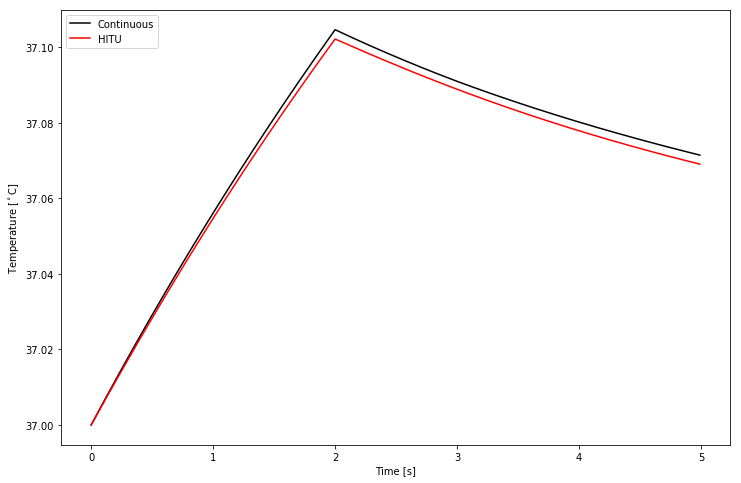

In [99]:
fig = plt.figure(figsize = (12,8))

plt.plot(time_domain, max_temp, c='black', label = 'Continuous')
plt.plot(time_domain, hitu_23, c='red', label = 'HITU')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

In [101]:
dif = np.max(np.abs(hitu_23 - max_temp))
print('Diferencia máxima de',dif, 'grados.')
print('Error porcentual de',100 * dif / (np.max(max_temp)-37),'%')

Diferencia máxima de 0.002470365728896695 grados.
Error porcentual de 2.3606019542857233 %


In [102]:
np.max(max_temp)

37.10464982139033

## Comentarios 

Los resultados indican que la simulación creada es cercana a nivel significativo de la entregada por HITU simulator en ambos casos. Esto implica que la simulación tiene un funcionamiento deseado en el contexto del problema.

Los parámetros usados en HITU simulator se observan en el documento adjunto WAKZK.m, mientras que los parámetros de tiempo se han cambiado directamente en el documento BHT.m con el tiempo deseado en cada simulación.